In [98]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from feature_eng import *
import os
from dotenv import load_dotenv

load_dotenv()

True

### load and check data 

In [100]:
#load Broome county data 

path = os.environ.get("path")
df = pd.read_csv(path)

In [101]:
df.columns

Index(['SBOEID', 'RZIP5', 'ED', 'LD', 'ENROLLMENT', 'REGDATE', 'STATUS',
       'voterhistory', 'DOB'],
      dtype='object')

In [63]:
data = df.rename(columns = {'VoterHistory':'voterhistory'})

data.columns 

Index(['SBOEID', 'RZIP5', 'ED', 'LD', 'ENROLLMENT', 'REGDATE', 'STATUS',
       'voterhistory', 'DOB'],
      dtype='object')

# Model Building and Testing

In [5]:
def compare_models_on_features(df_with_features, feature_cols, target_col='target', test_size=0.3, random_state=42):
    """
    Compare multiple models with fixed probability handling
    """
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.linear_model import LogisticRegression
    from lightgbm import LGBMClassifier
    from xgboost import XGBClassifier
    from sklearn.neural_network import MLPClassifier
    from sklearn.svm import SVC
    from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                                f1_score, roc_auc_score, confusion_matrix, 
                                classification_report)
    import time
    
    print("Preparing data for model comparison...")
    
    # Ensure we have the features
    X = df_with_features[feature_cols].fillna(0)
    y = df_with_features[target_col]
    
    # Check class distribution
    print(f"Target distribution: {y.value_counts()}")
    print(f"Target ratio: {y.mean():.3f}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    print(f"\nTraining set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")
    
    # Define models
    models = {
        'Logistic Regression': LogisticRegression(random_state=random_state, max_iter=1000),
        'Random Forest': RandomForestClassifier(
            n_estimators=100, 
            random_state=random_state,
            n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            random_state=random_state
        ),
        'LightGBM': LGBMClassifier(
            n_estimators=100,
            learning_rate=0.1,
            num_leaves=31,
            random_state=random_state,
            verbose=-1
        ),
        'XGBoost': XGBClassifier(
            n_estimators=100,
            learning_rate=0.1,
            random_state=random_state,
            use_label_encoder=False,
            eval_metric='logloss'
        )
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n{'='*50}")
        print(f"Training {name}...")
        
        start_time = time.time()
        
        try:
            # Train model
            model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test)
            
            # Handle probability predictions safely
            y_pred_proba = None
            auc_score = None
            
            if hasattr(model, "predict_proba"):
                try:
                    proba_result = model.predict_proba(X_test)
                    
                    # Check the shape of probability output
                    if proba_result.ndim == 2 and proba_result.shape[1] == 2:
                        # Binary classification with both classes
                        y_pred_proba = proba_result[:, 1]
                    elif proba_result.ndim == 2 and proba_result.shape[1] == 1:
                        # Only one class probability returned
                        y_pred_proba = proba_result[:, 0]
                    elif proba_result.ndim == 1:
                        # Single array of probabilities
                        y_pred_proba = proba_result
                    else:
                        print(f"Unexpected probability shape: {proba_result.shape}")
                        y_pred_proba = None
                        
                    if y_pred_proba is not None:
                        auc_score = roc_auc_score(y_test, y_pred_proba)
                        
                except Exception as e:
                    print(f"Error getting probabilities: {e}")
                    y_pred_proba = None
                    auc_score = None
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            
            # Confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            tn, fp, fn, tp = cm.ravel()
            
            # Training time
            training_time = time.time() - start_time
            
            # Store results
            results[name] = {
                'model': model,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'auc': auc_score,
                'confusion_matrix': cm,
                'true_negatives': tn,
                'false_positives': fp,
                'false_negatives': fn,
                'true_positives': tp,
                'training_time': training_time,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }
            
            # Print results
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1 Score: {f1:.4f}")
            if auc_score is not None:
                print(f"AUC: {auc_score:.4f}")
            else:
                print("AUC: Not available")
            print(f"Training time: {training_time:.2f} seconds")
            
            print(f"\nConfusion Matrix:")
            print(f"TN: {tn}, FP: {fp}")
            print(f"FN: {fn}, TP: {tp}")
            
        except Exception as e:
            print(f"Error training {name}: {e}")
            results[name] = {
                'error': str(e),
                'accuracy': 0,
                'auc': 0
            }
    
    # Create summary comparison
    print("\n" + "="*50)
    print("Model Comparison Summary:")
    print("="*50)
    
    summary_data = []
    for name, result in results.items():
        if 'error' not in result:
            summary_data.append({
                'Model': name,
                'Accuracy': f"{result['accuracy']:.4f}",
                'AUC': f"{result['auc']:.4f}" if result['auc'] is not None else "N/A",
                'Precision': f"{result['precision']:.4f}",
                'Recall': f"{result['recall']:.4f}",
                'F1': f"{result['f1']:.4f}",
                'Time (s)': f"{result['training_time']:.2f}"
            })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
    # Find best model by AUC (if available) or accuracy
    valid_results = {k: v for k, v in results.items() if 'error' not in v}
    
    # Sort by AUC if available, otherwise by accuracy
    if any(r['auc'] is not None for r in valid_results.values()):
        best_model = max(valid_results.items(), 
                        key=lambda x: x[1]['auc'] if x[1]['auc'] is not None else 0)
        metric_used = 'AUC'
    else:
        best_model = max(valid_results.items(), 
                        key=lambda x: x[1]['accuracy'])
        metric_used = 'Accuracy'
    
    print(f"\nBest model by {metric_used}: {best_model[0]}")
    
    return results

# Also create a function to safely get prediction probabilities
def safe_predict_proba(model, X):
    """
    Safely get prediction probabilities, handling different model outputs
    """
    if not hasattr(model, "predict_proba"):
        return None
    
    try:
        proba = model.predict_proba(X)
        
        # Handle different output shapes
        if proba.ndim == 2 and proba.shape[1] == 2:
            # Standard binary classification
            return proba[:, 1]
        elif proba.ndim == 2 and proba.shape[1] == 1:
            # Single column output
            return proba[:, 0]
        elif proba.ndim == 1:
            # Already 1D
            return proba
        else:
            print(f"Unexpected probability shape: {proba.shape}")
            return None
            
    except Exception as e:
        print(f"Error getting probabilities: {e}")
        return None

def visualize_model_comparison(results):
    """
    Visualize model comparison results
    
    Args:
        results: Dictionary with model results
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import seaborn as sns
    
    # Create a DataFrame with the results
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc', 'cv_mean']
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'CV AUC']
    
    data = []
    for model_name, metrics_dict in results.items():
        row = {'Model': model_name}
        for metric in metrics:
            if metric in metrics_dict and metrics_dict[metric] is not None:
                row[metric] = metrics_dict[metric]
            else:
                row[metric] = None
        data.append(row)
    
    df_metrics = pd.DataFrame(data)
    
    # Plot the metrics for each model
    plt.figure(figsize=(12, 8))
    df_plot = df_metrics.melt(
        id_vars=['Model'], 
        value_vars=[m for m in metrics if m != 'cv_mean'],
        var_name='Metric', value_name='Value'
    )
    
    # Map metric keys to friendly names
    metric_map = dict(zip(metrics, metric_names))
    df_plot['Metric'] = df_plot['Metric'].map(lambda x: metric_map.get(x, x))
    
    # Create the plot
    sns.barplot(x='Model', y='Value', hue='Metric', data=df_plot)
    plt.title('Model Comparison Across Metrics')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    
    # Plot cross-validation results
    plt.figure(figsize=(10, 6))
    cv_data = []
    for model_name, metrics_dict in results.items():
        if 'cv_scores' in metrics_dict:
            for score in metrics_dict['cv_scores']:
                cv_data.append({
                    'Model': model_name,
                    'CV AUC': score
                })
    
    df_cv = pd.DataFrame(cv_data)
    sns.boxplot(x='Model', y='CV AUC', data=df_cv)
    plt.title('Cross-validation AUC Scores')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Plot confusion matrices
    nrows = (len(results) + 2) // 3  # Calculate rows needed
    fig, axes = plt.subplots(nrows, 3, figsize=(15, 4 * nrows))
    axes = axes.flatten() if nrows > 1 else [axes]
    
    for i, (model_name, metrics_dict) in enumerate(results.items()):
        if i < len(axes) and 'confusion_matrix' in metrics_dict:
            ax = axes[i]
            cm = metrics_dict['confusion_matrix']
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'{model_name} Confusion Matrix')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_feature_importance(model, feature_names, model_name='Model'):
    """
    Visualize feature importance for a model
    
    Args:
        model: Trained model with feature_importances_ attribute
        feature_names: List of feature names
        model_name: Name of the model
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import seaborn as sns
    import numpy as np
    
    # Get feature importances
    importances = model.feature_importances_
    
    # Create a DataFrame for easier visualization
    df_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort by importance
    df_importances = df_importances.sort_values('Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=df_importances)
    plt.title(f'{model_name} Feature Importance')
    plt.tight_layout()
    plt.show()


In [95]:
#mayoral elections to train on
mayoral_election_dates = [
            '20211102',
            '20171107', 
            '20131105',
            '20091103',
            '20051108',
            '20011106'
        ]

train_df, feature_names = extract_clean_features_enhanced(data, parse_voter_history, mayoral_election_dates)

Extracting clean features from 146429 voter records
Parsing voter histories...
Kept 120751 voters with valid parsed histories
Deriving all election dates from voter histories...
Derived 59 election dates
Mayoral election years: [2021, 2017, 2013, 2009, 2005, 2001]
Local election years: [2003, 2007, 2011, 2015, 2019, 2023, 2027]
Extracting features...
Calculating first election information...
Calculating normalized participation rates...
Calculating mayoral and local participation rates...
Setting target variable...
Calculating voting trends...
Feature extraction complete
Extracting behavior change features...


In [65]:
train_df.columns

Index(['SBOEID', 'RZIP5', 'ED', 'LD', 'ENROLLMENT', 'REGDATE', 'STATUS',
       'voterhistory', 'DOB', 'parsed_history', 'has_voting_history',
       'total_votes', 'voted_general', 'voted_primary', 'voted_local',
       'is_consistent_voter', 'first_election_year', 'years_registered',
       'elections_since_first', 'participation_rate',
       'mayoral_participation_rate', 'local_participation_rate',
       'voted_last_mayoral', 'voting_trend', 'preferred_method',
       'prefers_early_voting', 'prefers_absentee', 'recent_method_change',
       'recency_score', 'early_to_middle_change', 'middle_to_recent_change',
       'participation_acceleration', 'avg_gap', 'gap_variability',
       'longest_participation_streak', 'recent_pattern_change',
       'participation_expansion', 'diversification_score',
       'has_behavior_change', 'years_since_last_change', 'change_direction'],
      dtype='object')

In [7]:
# Now compare different models
model_results = compare_models_on_features(train_df, feature_names, 'voted_last_mayoral')

# Get the best model
best_model_name = max(model_results.items(), key=lambda x: x[1]['auc'] if x[1]['auc'] is not None else 0)[0]
best_model = model_results[best_model_name]['model']

Preparing data for model comparison...
Target distribution: 0    86384
1    34367
Name: voted_last_mayoral, dtype: int64
Target ratio: 0.285

Training set: 84525 samples
Test set: 36226 samples

Training Logistic Regression...


/Library/Python/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9502
Precision: 0.9080
Recall: 0.9181
F1 Score: 0.9130
AUC: 0.9889
Training time: 7.40 seconds

Confusion Matrix:
TN: 24957, FP: 959
FN: 844, TP: 9466

Training Random Forest...
Accuracy: 0.9935
Precision: 0.9886
Recall: 0.9885
F1 Score: 0.9885
AUC: 0.9994
Training time: 1.34 seconds

Confusion Matrix:
TN: 25798, FP: 118
FN: 119, TP: 10191

Training Gradient Boosting...
Accuracy: 0.9867
Precision: 0.9775
Recall: 0.9758
F1 Score: 0.9766
AUC: 0.9983
Training time: 10.76 seconds

Confusion Matrix:
TN: 25684, FP: 232
FN: 250, TP: 10060

Training LightGBM...
Accuracy: 0.9947
Precision: 0.9878
Recall: 0.9938
F1 Score: 0.9908
AUC: 0.9996
Training time: 0.67 seconds

Confusion Matrix:
TN: 25789, FP: 127
FN: 64, TP: 10246

Training XGBoost...


/Library/Python/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [14:25:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9934
Precision: 0.9870
Recall: 0.9899
F1 Score: 0.9885
AUC: 0.9994
Training time: 0.47 seconds

Confusion Matrix:
TN: 25782, FP: 134
FN: 104, TP: 10206

Model Comparison Summary:
              Model Accuracy    AUC Precision Recall     F1 Time (s)
Logistic Regression   0.9502 0.9889    0.9080 0.9181 0.9130     7.40
      Random Forest   0.9935 0.9994    0.9886 0.9885 0.9885     1.34
  Gradient Boosting   0.9867 0.9983    0.9775 0.9758 0.9766    10.76
           LightGBM   0.9947 0.9996    0.9878 0.9938 0.9908     0.67
            XGBoost   0.9934 0.9994    0.9870 0.9899 0.9885     0.47

Best model by AUC: LightGBM


In [204]:
model_results

{'Logistic Regression': {'model': LogisticRegression(max_iter=1000, random_state=42),
  'accuracy': 0.9563685636856368,
  'precision': 0.9272211720226843,
  'recall': 0.9211267605633803,
  'f1': 0.9241639189825719,
  'auc': 0.9928236083165661,
  'confusion_matrix': array([[5096,  154],
         [ 168, 1962]]),
  'true_negatives': 5096,
  'false_positives': 154,
  'false_negatives': 168,
  'true_positives': 1962,
  'training_time': 2.7264599800109863,
  'y_pred': array([0, 0, 0, ..., 0, 0, 0]),
  'y_pred_proba': array([0.01317703, 0.00214133, 0.36519367, ..., 0.18061206, 0.47216481,
         0.0113504 ])},
 'Random Forest': {'model': RandomForestClassifier(n_jobs=-1, random_state=42),
  'accuracy': 0.9887533875338753,
  'precision': 0.989010989010989,
  'recall': 0.971830985915493,
  'f1': 0.980345725787355,
  'auc': 0.9988326849988822,
  'confusion_matrix': array([[5227,   23],
         [  60, 2070]]),
  'true_negatives': 5227,
  'false_positives': 23,
  'false_negatives': 60,
  'true_

## calibrating

In [8]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, brier_score_loss, precision_recall_curve
import joblib
import os


# Train the final model (lightgbm choosen)
def train_final_lightgbm_model(result_df, selected_features, random_state=42):
    """
    Train and calibrate the final LightGBM model for voter turnout prediction
    """
    print("Training final LightGBM model...")
    
    # Prepare data
    X = result_df[selected_features].copy()
    y = result_df['voted_last_mayoral'].copy()
    
    # Split data for training and testing
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state, stratify=y
    )
    
    print(f"Training data: {X_train.shape[0]} samples")
    print(f"Testing data: {X_test.shape[0]} samples")
    print(f"Target distribution: {np.bincount(y_train)}")
    
    # Define LightGBM parameters
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'n_estimators': 100,
        'learning_rate': 0.1,
        'num_leaves': 31,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'min_data_in_leaf': 50,
        'verbose': -1
    }
    
    # Train LightGBM model
    model = lgb.LGBMClassifier(**params, random_state=random_state)
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = (y_pred == y_test).mean()
    auc = roc_auc_score(y_test, y_proba)
    
    print(f"Model accuracy: {accuracy:.4f}")
    print(f"Model AUC: {auc:.4f}")
    
    # Calibrate probabilities
    print("\nCalibrating model probabilities...")
    calibrated_model = CalibratedClassifierCV(model, method='isotonic', cv='prefit')
    calibrated_model.fit(X_test, y_test)
    
    # Check calibration quality
    y_calibrated_proba = calibrated_model.predict_proba(X_test)[:, 1]
    brier_original = brier_score_loss(y_test, y_proba)
    brier_calibrated = brier_score_loss(y_test, y_calibrated_proba)
    
    print(f"Brier score before calibration: {brier_original:.4f}")
    print(f"Brier score after calibration: {brier_calibrated:.4f}")
    
    # Plot calibration curve
    plot_calibration_curve(y_test, y_proba, y_calibrated_proba)
    
    # Plot feature importance
    plot_feature_importance(model, selected_features)
    
    # Return both the raw and calibrated models
    return model, calibrated_model, y_test, y_proba

def plot_calibration_curve(y_test, y_proba, y_calibrated_proba):
    """Plot calibration curves for original and calibrated models"""
    from sklearn.calibration import calibration_curve
    
    plt.figure(figsize=(10, 6))
    
    # Original model calibration curve
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
    plt.plot(prob_pred, prob_true, 's-', label='Original model')
    
    # Calibrated model calibration curve
    prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_calibrated_proba, n_bins=10)
    plt.plot(prob_pred_cal, prob_true_cal, 's-', label='Calibrated model')
    
    # Perfect calibration line
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
    
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration Curve')
    plt.legend(loc='best')
    plt.grid(True)
    plt.savefig('calibration_curve.png')
    plt.close()

def plot_feature_importance(model, features):
    """Plot feature importance from the model"""
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title('LightGBM Feature Importance')
    plt.bar(range(len(importance)), importance[indices], align='center')
    plt.xticks(range(len(importance)), [features[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.savefig('lightgbm_feature_importance.png')
    plt.close()
    

In [9]:
train_df.columns

Index(['SBOEID', 'RZIP5', 'ED', 'LD', 'ENROLLMENT', 'REGDATE', 'STATUS',
       'voterhistory', 'DOB', 'parsed_history', 'has_voting_history',
       'total_votes', 'voted_general', 'voted_primary', 'voted_local',
       'is_consistent_voter', 'first_election_year', 'years_registered',
       'elections_since_first', 'participation_rate',
       'mayoral_participation_rate', 'local_participation_rate',
       'voted_last_mayoral', 'voting_trend', 'preferred_method',
       'prefers_early_voting', 'prefers_absentee', 'recent_method_change',
       'recency_score', 'early_to_middle_change', 'middle_to_recent_change',
       'participation_acceleration', 'avg_gap', 'gap_variability',
       'longest_participation_streak', 'recent_pattern_change',
       'participation_expansion', 'diversification_score',
       'has_behavior_change', 'years_since_last_change', 'change_direction'],
      dtype='object')

In [10]:
model, calibrated_model = train_final_lightgbm_model(train_df, feature_names)

Training final LightGBM model...
Training data: 96600 samples
Testing data: 24151 samples
Target distribution: [69107 27493]
Model accuracy: 0.9948
Model AUC: 0.9996

Calibrating model probabilities...
Brier score before calibration: 0.0043
Brier score after calibration: 0.0041


## Feature anaylsis 

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

def feature_inference(model, X, y, feature_names=None, top_n=10):
    """
    Simple statistical inference for feature importance in your voter model.
    Handles pandas DataFrame conversion issues and prevents common errors.
    
    Parameters:
    -----------
    model : your trained model (lightgbm, etc.)
    X : pandas DataFrame of features 
    y : pandas Series of target variable
    feature_names : list of feature names (optional, will use X.columns if None)
    top_n : number of top features to analyze
    
    Returns:
    --------
    DataFrame with statistical inference results
    """
    # If feature_names not provided, use DataFrame columns
    if feature_names is None:
        feature_names = X.columns.tolist()
    
    # 1. Get model's feature importance 
    importance = model.feature_importances_ if hasattr(model, 'feature_importances_') else None
    
    # 2. Convert data for statsmodels (fix object dtype error)
    print("Converting data for statistical analysis...")
    
    # Make a copy to avoid modifying the original
    X_copy = X.copy()
    
    # Ensure all columns are numeric (convert any object types)
    for col in X_copy.columns:
        if X_copy[col].dtype == 'object':
            print(f"Converting column {col} from object to numeric")
            X_copy[col] = pd.to_numeric(X_copy[col], errors='coerce')
    
    # Check for any remaining object columns
    object_cols = X_copy.select_dtypes(include=['object']).columns.tolist()
    if object_cols:
        print(f"Warning: Dropping these object columns that couldn't be converted: {object_cols}")
        X_copy = X_copy.drop(columns=object_cols)
        
    # Check for NaN values and fill them
    if X_copy.isna().any().any():
        print("Filling NaN values with 0")
        X_copy = X_copy.fillna(0)
    
    # 3. Run logistic regression for inference
    print("Running logistic regression for statistical inference...")
    try:
        X_sm = sm.add_constant(X_copy)
        logit = sm.Logit(y, X_sm).fit(disp=0)
        
        # 4. Compile results
        results = pd.DataFrame({
            'Feature': ['const'] + list(X_copy.columns),
            'Coefficient': logit.params,
            'Std_Error': logit.bse,
            'p_value': logit.pvalues,
            'Odds_Ratio': np.exp(logit.params)
        })
        
        # 5. Add model importance if available
        if importance is not None:
            # Make sure feature_names match the X_copy columns used in the regression
            valid_features = X_copy.columns.tolist()
            feature_indices = [i for i, f in enumerate(feature_names) if f in valid_features]
            
            if feature_indices:
                valid_importance = [importance[i] for i in feature_indices]
                imp_df = pd.DataFrame({
                    'Feature': valid_features,
                    'Model_Importance': valid_importance[:len(valid_features)]
                })
                results = results.merge(imp_df, on='Feature', how='left')
        
        # 6. Sort by statistical significance
        results = results.sort_values('p_value')
        
        # Display top features
        print(f"\nTop {top_n} Statistically Significant Features:")
        pd.set_option('display.float_format', '{:.4f}'.format)
        print(results.head(top_n)[['Feature', 'Coefficient', 'p_value', 'Odds_Ratio']])
        
        # Simple visualization of odds ratios (excluding intercept)
        plt.figure(figsize=(10, 6))
        top_features = results.iloc[1:top_n+1]  # Skip intercept
        
        # Plot the odds ratios
        plt.errorbar(
            top_features['Odds_Ratio'], 
            range(len(top_features)),
            xerr=top_features['Std_Error'] * top_features['Odds_Ratio'],
            fmt='o',
            capsize=5
        )
        
        plt.axvline(x=1, color='red', linestyle='--')
        plt.yticks(range(len(top_features)), top_features['Feature'])
        plt.xscale('log')
        plt.xlabel('Odds Ratio (log scale)')
        plt.title(f'Effect of Features on Voter Turnout (95% CI)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return results
    
    except Exception as e:
        print(f"Error in regression analysis: {e}")
        print("\nTrying alternative approach with simpler feature importance analysis...")
        
        # If regression fails, at least return model's feature importance
        if importance is not None:
            simple_results = pd.DataFrame({
                'Feature': feature_names,
                'Model_Importance': importance
            }).sort_values('Model_Importance', ascending=False)
            
            print("\nTop features by model importance:")
            print(simple_results.head(top_n))
            
            # Simple visualization
            plt.figure(figsize=(10, 6))
            sns.barplot(x='Model_Importance', y='Feature', data=simple_results.head(top_n))
            plt.title('Feature Importance from Model')
            plt.tight_layout()
            plt.show()
            
            return simple_results
        else:
            print("Could not perform statistical inference and model has no feature_importances_")
            return None

Converting data for statistical analysis...
Converting column SBOEID from object to numeric
Converting column ENROLLMENT from object to numeric
Converting column STATUS from object to numeric
Converting column voterhistory from object to numeric
Converting column parsed_history from object to numeric
Converting column preferred_method from object to numeric
Filling NaN values with 0
Running logistic regression for statistical inference...


/Library/Python/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Error in regression analysis: Singular matrix

Trying alternative approach with simpler feature importance analysis...

Top features by model importance:
                       Feature  Model_Importance
26     years_since_last_change               497
15               recency_score               430
11  mayoral_participation_rate               308
27            change_direction               257
17     middle_to_recent_change               203
12    local_participation_rate               142
16      early_to_middle_change               139
13                voting_trend               136
19                     avg_gap               120
20             gap_variability               114


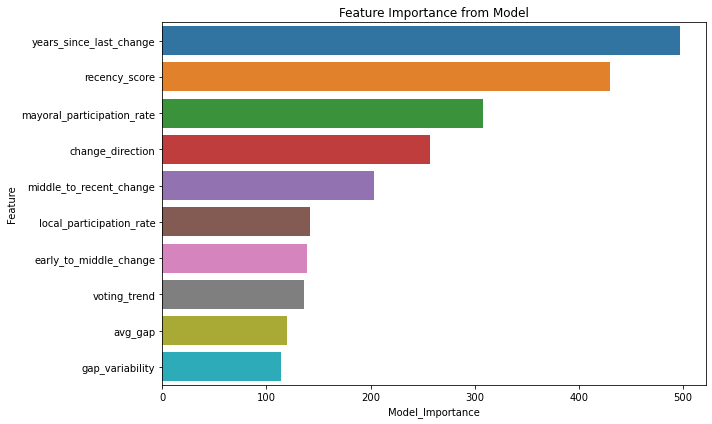

,Feature,Model_Importance
26,years_since_last_change,497
15,recency_score,430
11,mayoral_participation_rate,308
27,change_direction,257
17,middle_to_recent_change,203
12,local_participation_rate,142
16,early_to_middle_change,139
13,voting_trend,136
19,avg_gap,120
20,gap_variability,114


In [19]:
X = train_df.drop(columns = ['voted_last_mayoral'])
y = train_df['voted_last_mayoral']

feature_inference(model, X, y, feature_names)

### Feature Categories by Total Importance:

- Temporal Pattern Features (96,177) - 35%
- Behavior Change Features (76,846) - 28%
- Participation Rate Features (55,467) - 20%
- Sequence Features (24,881) - 9%
- Diversity Features (10,822) - 4%
- Basic Features (7,757) - 3%
- Demographic Features (6,923) - 2%

## backtest final model

In [80]:
def working_backtest(voter_df, model, feature_cols, test_years=[2017, 2013], mayoral_election_dates=None):
    """
    Fixed backtest that properly handles all voters and features
    """
    if mayoral_election_dates is None:
        mayoral_election_dates = [
            '20211102',
            '20171107', 
            '20131105',
            '20091103',
            '20051108',
            '20011106'
        ]
    
    results = {}
    
    for year in test_years:
        print(f"\n=== Backtesting {year} ===")
        
        # 1. Create a working copy and preserve original index
        working_df = voter_df.copy()
        working_df['original_index'] = working_df.index
        
        # 2. Determine actual turnout for ALL voters
        actual_votes = np.zeros(len(working_df))

        for i, row in enumerate(working_df.itertuples(index=False)):
            history = parse_voter_history(row.voterhistory)
            for event in history:
                if event['year'] == year:
                    actual_votes[i] = 1
                    break  # Found a match

        working_df['actual_turnout'] = actual_votes
        actual_count = sum(actual_votes)
        print(f"Actual voters: {actual_count}/{len(working_df)} = {actual_count/len(working_df):.1%}")
        
        # 3. Filter histories to before test year
        filtered_histories = []
        voters_with_history = 0
        
        for idx, row in working_df.iterrows():
            history = parse_voter_history(row['voterhistory'])
            past_events = [e for e in history if e['year'] < year]
            
            if past_events:
                voters_with_history += 1
                history_str = ';'.join([
                    f"{e['year']} {e['election_name']}({e['vote_method']})"
                    for e in past_events
                ])
            else:
                history_str = ""
            
            filtered_histories.append(history_str)
        
        working_df['voterhistory'] = filtered_histories
        print(f"Voters with history before {year}: {voters_with_history}")
        
        # 4. Get mayoral dates before test year
        past_mayoral_dates = [d for d in mayoral_election_dates if int(d[:4]) < year]
        print(f"Using mayoral dates: {[d[:4] for d in past_mayoral_dates]}")
        
        # 5. Extract features - this will filter to valid histories
        features_df, returned_feature_names = extract_clean_features_enhanced(
            working_df,
            parse_voter_history,
            past_mayoral_dates
        )
        
        print(f"Features extracted for: {len(features_df)} voters")
        print(f"Returned features: {len(returned_feature_names)}")
        
        # 6. Create feature matrix using the features we want to use for prediction
        if not set(feature_cols).issubset(set(features_df.columns)):
            missing = set(feature_cols) - set(features_df.columns)
            print(f"WARNING: Missing features: {missing}")
        
        X = features_df[feature_cols].fillna(0)
        y_true = working_df.loc[features_df.index, 'actual_turnout']
        
        print(f"Final prediction matrix shape: {X.shape}")
        print(f"Eligible voters: {len(X)}")
        print(f"Eligible turnout: {y_true.mean():.1%}")
        
        # 7. Make predictions
        y_proba = model.predict_proba(X)[:, 1]
        y_pred = (y_proba >= 0.5).astype(int)
        
        # 8. Calculate metrics
        from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
        
        accuracy = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_proba)
        
        
        # 9. Segment analysis
        segment_df = pd.DataFrame({
            'actual': y_true,
            'predicted_proba': y_proba
        })
        
        bins = [0, 0.25, 0.5, 0.75, 1.0]
        segment_df['segment'] = pd.cut(y_proba, bins=bins, labels=['Low', 'Med-Low', 'Med-High', 'High'])
        
        segment_stats = segment_df.groupby('segment').agg({
            'actual': ['mean', 'count'],
            'predicted_proba': 'mean'
        })
        
        # Calculate projected turnout for each segment
        segment_stats['projected_voters'] = segment_stats[('predicted_proba', 'mean')] * segment_stats[('actual', 'count')]

        # Calculate total projected turnout
        total_voters = segment_stats[('actual', 'count')].sum()
        total_projected_turnout = segment_stats['projected_voters'].sum()
        projected_turnout_rate = total_projected_turnout / total_voters
        
        print(f"\nResults:")
        print(f"Accuracy: {accuracy:.3f}")
        print(f"AUC: {auc:.3f}")
        print(f"Actual turnout: {y_true.mean():.1%}")
        print(f"Predicted turnout: {projected_turnout_rate:.1%}")
        print(f"Error: {abs(y_true.mean() - projected_turnout_rate):.1%}")
        
        print("\nSegment Analysis:")
        print(segment_stats)
        
        # Store results
        results[year] = {
            'accuracy': accuracy,
            'auc': auc,
            'actual_turnout': y_true.mean(),
            'predicted_turnout': y_proba.mean(),
            'segment_stats': segment_stats,
            'predictions': y_proba,
            'actuals': y_true
        }
    
    return results

In [81]:
# Run the fixed backtest
results = working_backtest(
    train_df,
    model,
    feature_names,  # These are the 28 features the model was trained on
    test_years=[2017, 2013],
    mayoral_election_dates=['20211102', '20171107', '20131105', '20091103']
)


=== Backtesting 2017 ===
Actual voters: 34063.0/120751 = 28.2%
Voters with history before 2017: 87418
Using mayoral dates: ['2013', '2009']
Extracting clean features from 120751 voter records
Parsing voter histories...
Kept 87418 voters with valid parsed histories
Deriving all election dates from voter histories...
Derived 43 election dates
Mayoral election years: [2013, 2009]
Local election years: [2003, 2007, 2011, 2015, 2019, 2023, 2027]
Extracting features...
Calculating first election information...
Calculating normalized participation rates...
Calculating mayoral and local participation rates...
Setting target variable...
Calculating voting trends...
Feature extraction complete
Extracting behavior change features...
Features extracted for: 87418 voters
Returned features: 28
Final prediction matrix shape: (87418, 28)
Eligible voters: 87418
Eligible turnout: 38.2%

Results:
Accuracy: 0.694
AUC: 0.741
Actual turnout: 38.2%
Predicted turnout: 9.5%
Error: 28.7%

Segment Analysis:
   

### save model

In [82]:
def save_model(model, calibrated_model, features, output_dir='model'):
    """Save the model, calibrated model, and feature information"""
    # Create directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Save models
    joblib.dump(model, os.path.join(output_dir, 'lightgbm_model.joblib'))
    joblib.dump(calibrated_model, os.path.join(output_dir, 'calibrated_lightgbm_model.joblib'))
    
    # Save feature list
    with open(os.path.join(output_dir, 'model_features.txt'), 'w') as f:
        for feature in features:
            f.write(f"{feature}\n")
    
    # Save metadata
    metadata = {
        'model_type': 'LightGBM',
        'feature_count': len(features),
        'calibration_method': 'isotonic',
        'training_date': pd.Timestamp.now().strftime('%Y-%m-%d')
    }
    
    # Write as JSON file
    import json
    with open(os.path.join(output_dir, 'model_metadata.json'), 'w') as f:
        json.dump(metadata, f, indent=4)
    
    print(f"Models and metadata saved to {output_dir}")
    return output_dir



In [83]:
save_model(model, calibrated_model, feature_names)

Models and metadata saved to model


'model'